<a href="https://colab.research.google.com/github/Aditya01237/machine_learning_/blob/main/MachineLearningFinal_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MachineLearning
Final notebook with EDA (train.csv), models, merge for XGBoost, Optuna (120 trials), and full Decision Tree visualization.

In [16]:
# Install & imports (Colab-ready)
!pip install optuna --quiet

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier, plot_importance
import optuna

sns.set(style='whitegrid', palette='crest', font_scale=1.05)
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (10, 6)

def plot_clean_confusion_matrix(y_true, y_pred, labels, title, cmap='Greens', figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    for txt in ax.texts:
        txt.set_fontsize(11)
        txt.set_fontweight('bold')
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, pad=15)
    plt.grid(False)
    plt.tight_layout(pad=3)
    plt.show()


Shape: (15533, 18)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


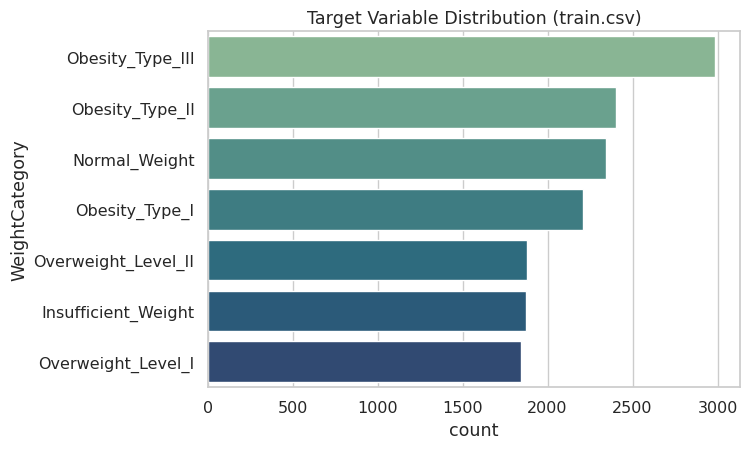

In [17]:
# Section A: EDA & Cleaning on train.csv
df = pd.read_csv('train.csv')
print('Shape:', df.shape)
display(df.head())
plt.figure(figsize=(8,5))
sns.countplot(data=df, y='WeightCategory', order=df['WeightCategory'].value_counts().index, palette='crest')
plt.title('Target Variable Distribution (train.csv)')
plt.tight_layout(pad=2)
plt.show()


In [18]:
# Preprocessing & 3-way split (train.csv only)
df = df.drop_duplicates().reset_index(drop=True)
y = df['WeightCategory']
X = df.drop(['id','WeightCategory'], axis=1, errors='ignore')
le = LabelEncoder(); y_encoded = le.fit_transform(y)

numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
ordinal_features = ['CAEC','CALC']
nominal_features = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']

caec_order = sorted(df['CAEC'].dropna().unique())
calc_order = sorted(df['CALC'].dropna().unique())

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=[caec_order, calc_order]), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features)
], remainder='passthrough')

# 60/20/20 split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
print('Train/Val/Test sizes:', X_train.shape[0], X_val.shape[0], X_test.shape[0])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

try:
    nom_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features).tolist()
except Exception:
    nom_names = []
feature_names = numeric_features + ordinal_features + nom_names
print('Processed feature count:', X_train_processed.shape[1])


Train/Val/Test sizes: 9319 3107 3107
Processed feature count: 25


Default Decision Tree - Validation Accuracy: 83.20%


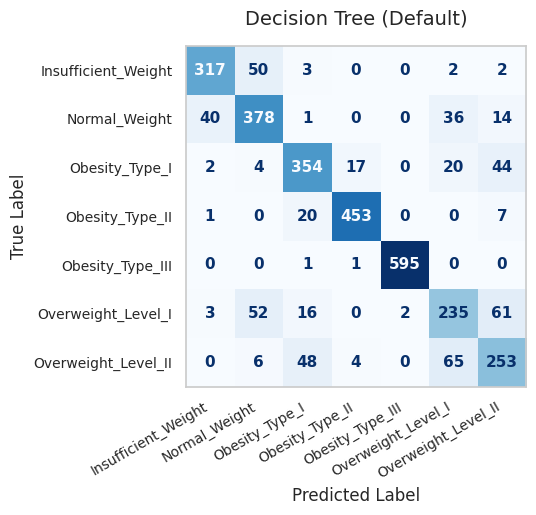

In [19]:
# Decision Tree - Default
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_processed, y_train)
y_pred_dt = dt.predict(X_val_processed)
acc_dt = accuracy_score(y_val, y_pred_dt)
print(f'Default Decision Tree - Validation Accuracy: {acc_dt*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_dt, le.classes_, 'Decision Tree (Default)', cmap='Blues')


Best params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}
Tuned Decision Tree - Validation Accuracy: 87.16%


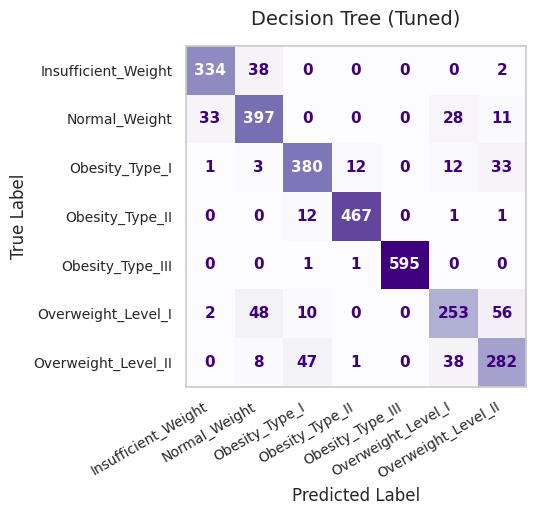

In [20]:
# Decision Tree - Tuned (GridSearchCV)
param_grid_dt = {'criterion':['gini','entropy'], 'max_depth':[5,10,15,20,None], 'min_samples_leaf':[1,2,5,10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_processed, y_train)
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_val_processed)
acc_best_dt = accuracy_score(y_val, y_pred_best_dt)
print('Best params:', grid_dt.best_params_)
print(f'Tuned Decision Tree - Validation Accuracy: {acc_best_dt*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_best_dt, le.classes_, 'Decision Tree (Tuned)', cmap='Purples')


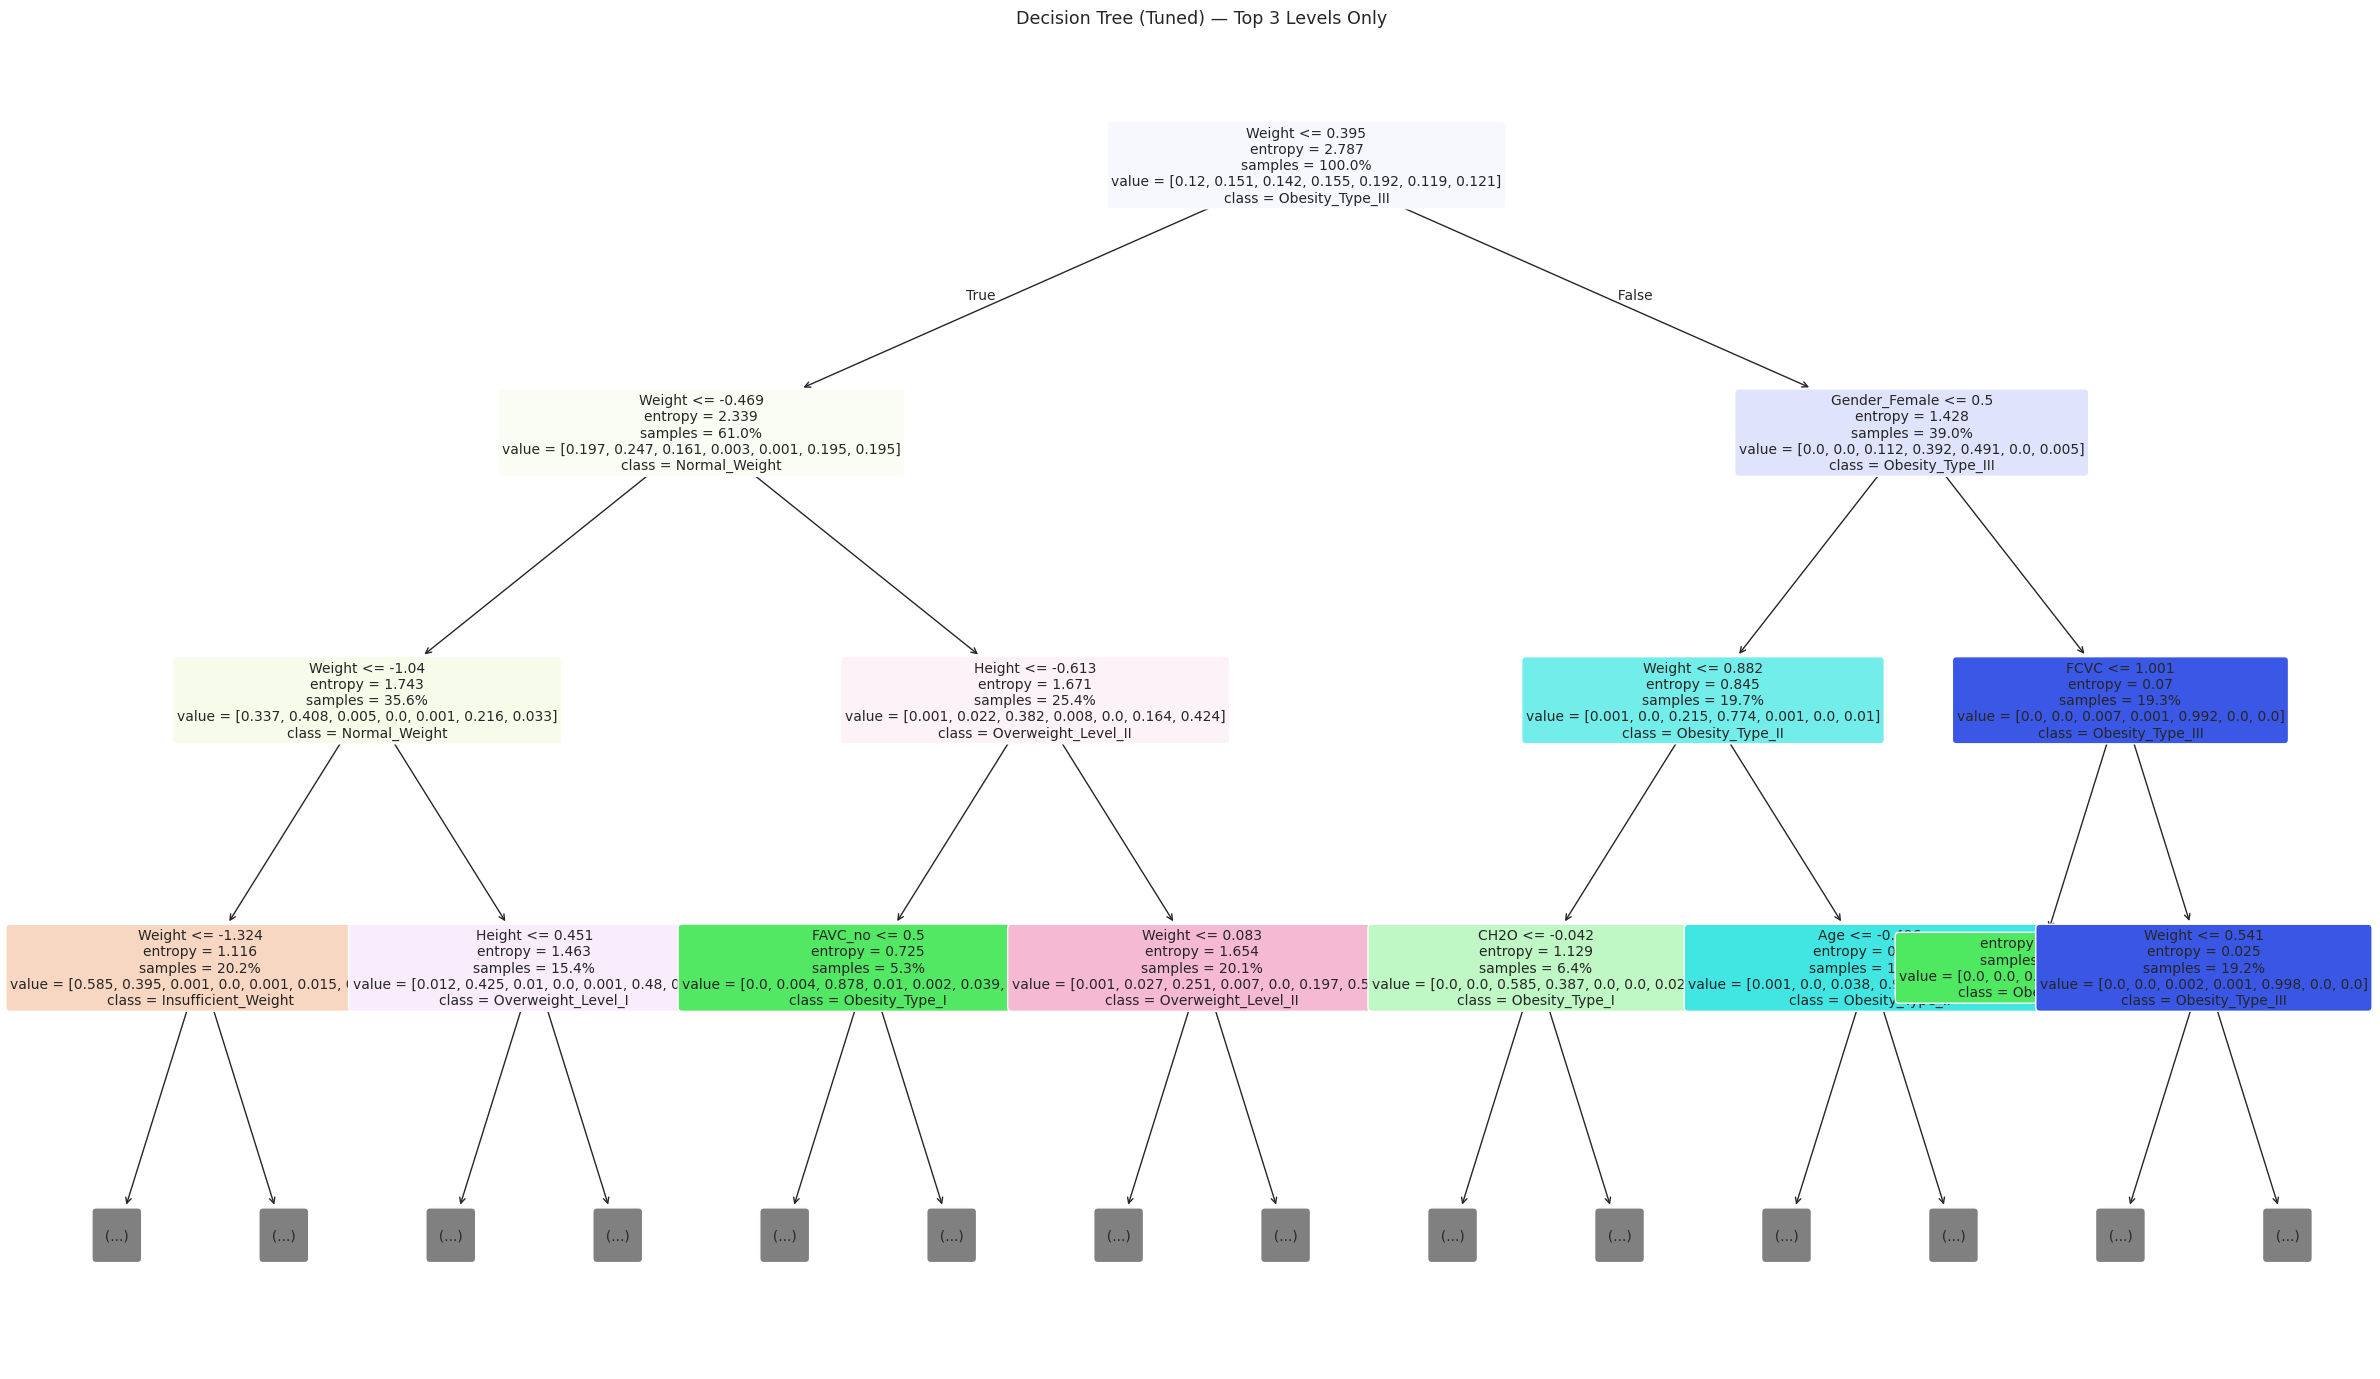

In [21]:
plt.figure(figsize=(25, 15))
plot_tree(
    best_dt,
    filled=True,
    feature_names=feature_names,
    class_names=le.classes_,
    fontsize=10,
    rounded=True,
    proportion=True,
    max_depth=3   # 👈 Show only first 3 levels
)
plt.title('Decision Tree (Tuned) — Top 3 Levels Only')
plt.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.05)
plt.tight_layout(pad=4)
plt.show()

Default Random Forest - Validation Accuracy: 88.22%


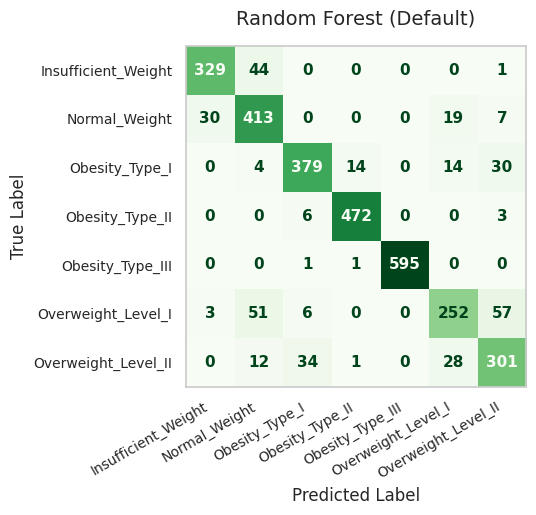

In [22]:
# Random Forest - Default
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_val_processed)
acc_rf = accuracy_score(y_val, y_pred_rf)
print(f'Default Random Forest - Validation Accuracy: {acc_rf*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_rf, le.classes_, 'Random Forest (Default)', cmap='Greens')


Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}
Tuned Random Forest - Validation Accuracy: 88.35%


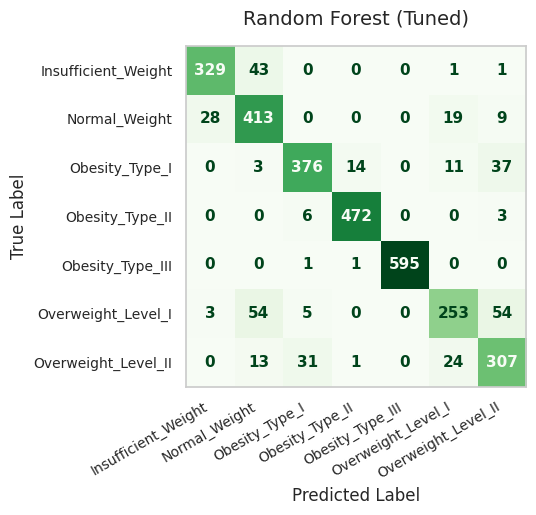

In [23]:
# Random Forest - Tuned (GridSearchCV)
param_grid_rf = {'n_estimators':[100,200,400], 'max_depth':[10,20,None], 'min_samples_leaf':[1,2,5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_processed, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_val_processed)
acc_best_rf = accuracy_score(y_val, y_pred_best_rf)
print('Best params:', grid_rf.best_params_)
print(f'Tuned Random Forest - Validation Accuracy: {acc_best_rf*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_best_rf, le.classes_, 'Random Forest (Tuned)', cmap='Greens')


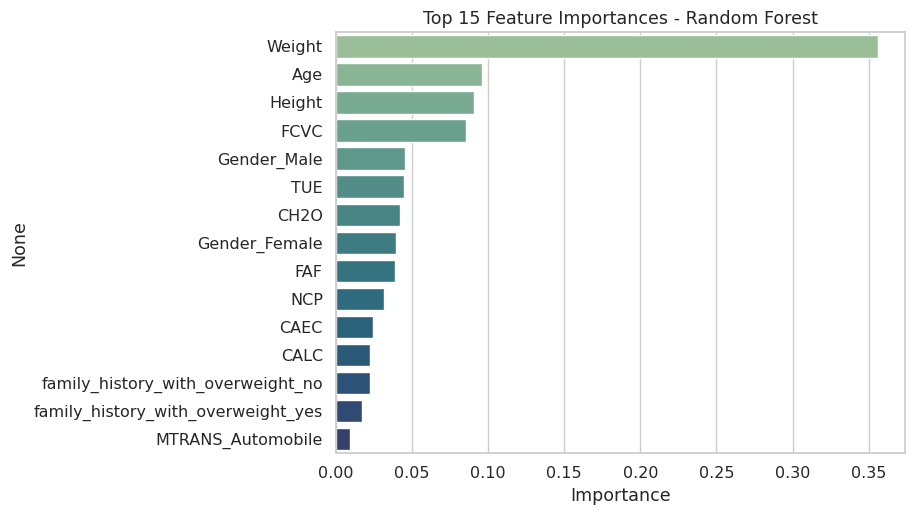

In [24]:
# Random Forest - Feature Importance (Top 15)
importances_rf = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(10,6))
sns.barplot(x=importances_rf.values, y=importances_rf.index, palette='crest')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout(pad=3)
plt.show()


Default Gradient Boosting - Validation Accuracy: 89.93%


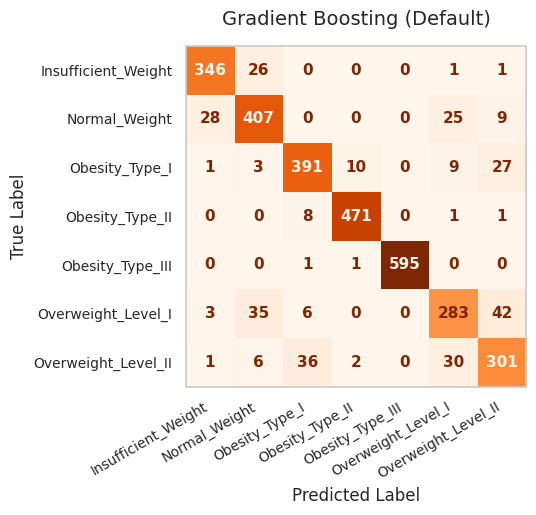

In [25]:
# Gradient Boosting - Default
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_processed, y_train)
y_pred_gb = gb.predict(X_val_processed)
acc_gb = accuracy_score(y_val, y_pred_gb)
print(f'Default Gradient Boosting - Validation Accuracy: {acc_gb*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_gb, le.classes_, 'Gradient Boosting (Default)', cmap='Oranges')


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Tuned Gradient Boosting - Validation Accuracy: 89.89%


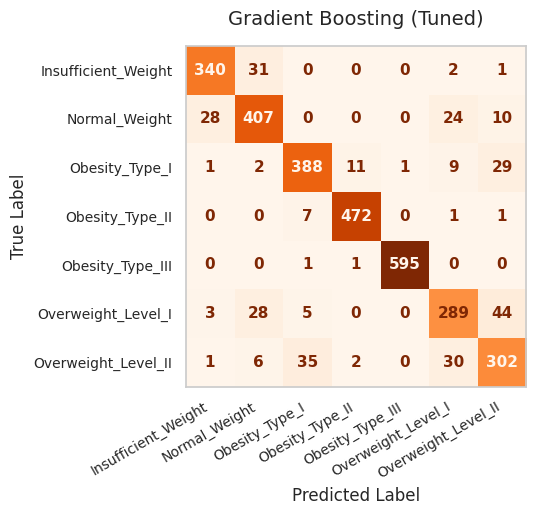

In [27]:
# Gradient Boosting - Tuned (GridSearchCV reduced)
param_grid_gb = {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_processed, y_train)
best_gb = grid_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_val_processed)
acc_best_gb = accuracy_score(y_val, y_pred_best_gb)
print('Best params:', grid_gb.best_params_)
print(f'Tuned Gradient Boosting - Validation Accuracy: {acc_best_gb*100:.2f}%')
plot_clean_confusion_matrix(y_val, y_pred_best_gb, le.classes_, 'Gradient Boosting (Tuned)', cmap='Oranges')


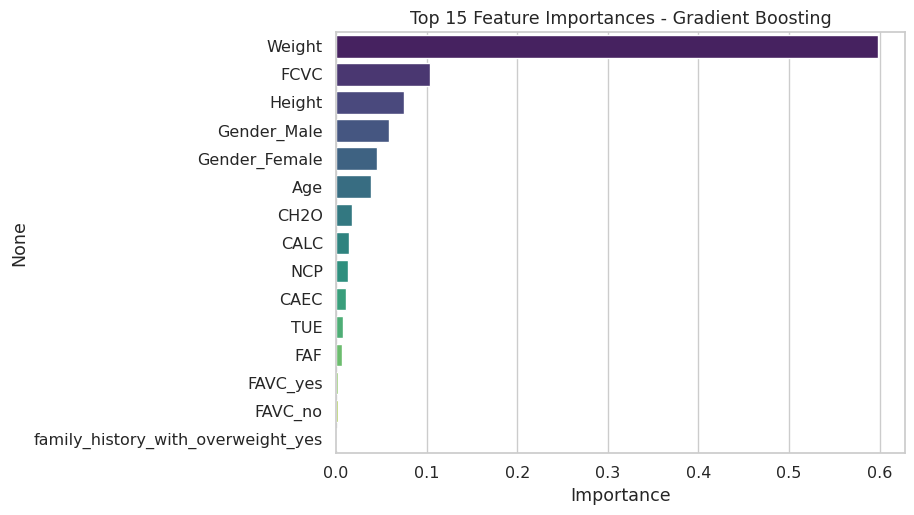

In [28]:
# Gradient Boosting - Feature Importance (Top 15)
importances_gb = pd.Series(best_gb.feature_importances_, index=feature_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(10,6))
sns.barplot(x=importances_gb.values, y=importances_gb.index, palette='viridis')
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.xlabel('Importance')
plt.tight_layout(pad=3)
plt.show()


## Merge train.csv + ObesityDataSet.csv for XGBoost and preprocess

In [29]:
df_comp = pd.read_csv('train.csv')
df_orig = pd.read_csv('ObesityDataSet.csv')
if 'NObeyesdad' in df_orig.columns:
    df_orig.rename(columns={'NObeyesdad':'WeightCategory'}, inplace=True)
df_merged = pd.concat([df_comp, df_orig], ignore_index=True).drop_duplicates().reset_index(drop=True)
print('Merged shape:', df_merged.shape)
display(df_merged.head())


Merged shape: (17620, 18)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [30]:
# Preprocess merged dataset and 3-way split
dfm = df_merged.copy()
y_m = dfm['WeightCategory']
X_m = dfm.drop(['id','WeightCategory'], axis=1, errors='ignore')
le_m = LabelEncoder(); y_m_enc = le_m.fit_transform(y_m)
numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
ordinal_features = ['CAEC','CALC']
nominal_features = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']
caec_order_m = sorted(dfm['CAEC'].dropna().unique()); calc_order_m = sorted(dfm['CALC'].dropna().unique())
preprocessor_m = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=[caec_order_m, calc_order_m]), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features)
], remainder='passthrough')
X_train_val_m, X_test_m, y_train_val_m, y_test_m = train_test_split(X_m, y_m_enc, test_size=0.2, random_state=42, stratify=y_m_enc)
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_val_m, y_train_val_m, test_size=0.25, random_state=42, stratify=y_train_val_m)
X_train_processed_m = preprocessor_m.fit_transform(X_train_m)
X_val_processed_m = preprocessor_m.transform(X_val_m)
X_test_processed_m = preprocessor_m.transform(X_test_m)
try:
    nom_names_m = preprocessor_m.named_transformers_['nom'].get_feature_names_out(nominal_features).tolist()
except Exception:
    nom_names_m = []
feature_names_m = numeric_features + ordinal_features + nom_names_m
print('Merged processed feature count:', X_train_processed_m.shape[1])


Merged processed feature count: 25


Default XGBoost (merged) - Validation Accuracy: 90.78%


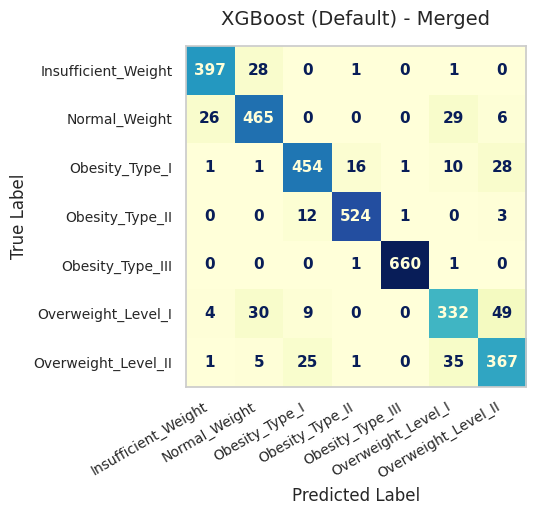

In [31]:
# XGBoost - Default on merged data
xgb_default_m = XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)
xgb_default_m.fit(X_train_processed_m, y_train_m)
y_pred_xgb_default_m = xgb_default_m.predict(X_val_processed_m)
acc_xgb_default_m = accuracy_score(y_val_m, y_pred_xgb_default_m)
print(f'Default XGBoost (merged) - Validation Accuracy: {acc_xgb_default_m*100:.2f}%')
plot_clean_confusion_matrix(y_val_m, y_pred_xgb_default_m, le_m.classes_, 'XGBoost (Default) - Merged', cmap='YlGnBu')


In [34]:
# XGBoost - Optuna hypertuning (120 trials). This can take significant time.
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = XGBClassifier(**params, random_state=42, eval_metric='mlogloss', use_label_encoder=False)
    model.fit(X_train_processed_m, y_train_m, eval_set=[(X_val_processed_m, y_val_m)], verbose=False)
    preds = model.predict(X_val_processed_m)
    return accuracy_score(y_val_m, preds)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=120, n_jobs=-1)
print('Optuna best value:', study_xgb.best_value)
print('Optuna best params:', study_xgb.best_params)


[I 2025-11-05 16:33:42,855] A new study created in memory with name: no-name-3d8ddaf1-e945-4438-8f76-9fa6a38c27b1
[I 2025-11-05 16:34:00,066] Trial 0 finished with value: 0.9026674233825198 and parameters: {'n_estimators': 222, 'learning_rate': 0.0031423629519057735, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.9609492075955882, 'subsample': 0.805913561459545, 'colsample_bytree': 0.5220721846483997, 'reg_alpha': 0.09665785040228747, 'reg_lambda': 0.387161999434275}. Best is trial 0 with value: 0.9026674233825198.
[I 2025-11-05 16:34:17,134] Trial 2 finished with value: 0.9100454029511919 and parameters: {'n_estimators': 788, 'learning_rate': 0.05260482329648587, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.9557947583190383, 'subsample': 0.8357673811535129, 'colsample_bytree': 0.5896790474404032, 'reg_alpha': 0.12886950807813302, 'reg_lambda': 0.15341603525351366}. Best is trial 2 with value: 0.9100454029511919.
[I 2025-11-05 16:34:20,329] Trial 1 finished with value: 0.9111

Optuna best value: 0.9177071509648127
Optuna best params: {'n_estimators': 1897, 'learning_rate': 0.012380972995811677, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.1567505578776076, 'subsample': 0.8997855307462038, 'colsample_bytree': 0.5086144212706162, 'reg_alpha': 0.5590443745627882, 'reg_lambda': 0.19791121592196992}


XGBoost (Tuned manual params) - Validation Accuracy: 91.46%
XGBoost (Tuned manual params) - Test Accuracy: 92.31%


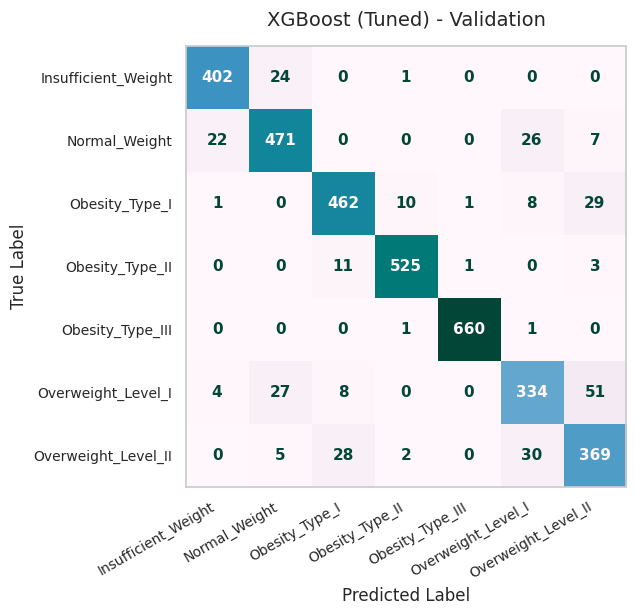

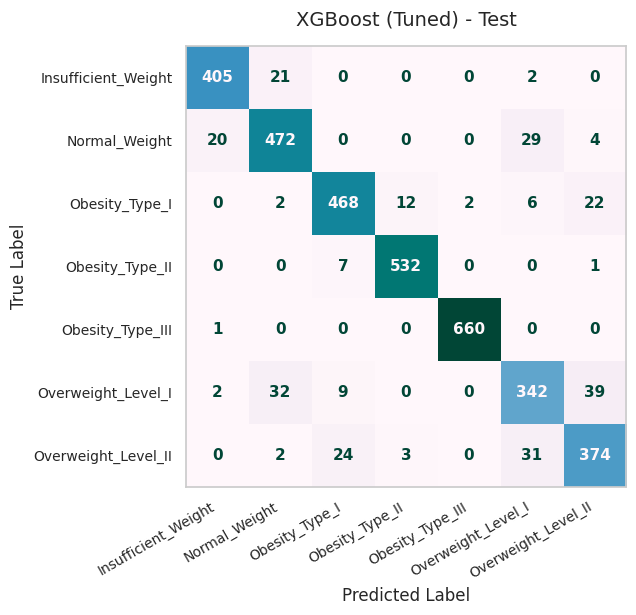

In [35]:
# XGBoost - Final using provided best params (train on merged train)
xgb_best_params_manual = {
    'n_estimators': 1513,
    'learning_rate': 0.012431605154009283,
    'max_depth': 10,
    'min_child_weight': 4,
    'gamma': 0.5366604488436517,
    'subsample': 0.6715889901631579,
    'colsample_bytree': 0.5042432952363623621,
    'reg_alpha': 0.6169148162578733,
    'reg_lambda': 0.9131611182392163
}
xgb_tuned_m = XGBClassifier(**xgb_best_params_manual, random_state=42, eval_metric='mlogloss', use_label_encoder=False)
xgb_tuned_m.fit(X_train_processed_m, y_train_m)
y_pred_xgb_tuned_m = xgb_tuned_m.predict(X_val_processed_m)
acc_xgb_tuned_m = accuracy_score(y_val_m, y_pred_xgb_tuned_m)
print(f'XGBoost (Tuned manual params) - Validation Accuracy: {acc_xgb_tuned_m*100:.2f}%')
y_test_pred_xgb = xgb_tuned_m.predict(X_test_processed_m)
test_acc_xgb = accuracy_score(y_test_m, y_test_pred_xgb)
print(f'XGBoost (Tuned manual params) - Test Accuracy: {test_acc_xgb*100:.2f}%')
plot_clean_confusion_matrix(y_val_m, y_pred_xgb_tuned_m, le_m.classes_, 'XGBoost (Tuned) - Validation', cmap='PuBuGn', figsize=(9,7))
plot_clean_confusion_matrix(y_test_m, y_test_pred_xgb, le_m.classes_, 'XGBoost (Tuned) - Test', cmap='PuBuGn', figsize=(9,7))


Decision Tree - Test Accuracy: 87.22%


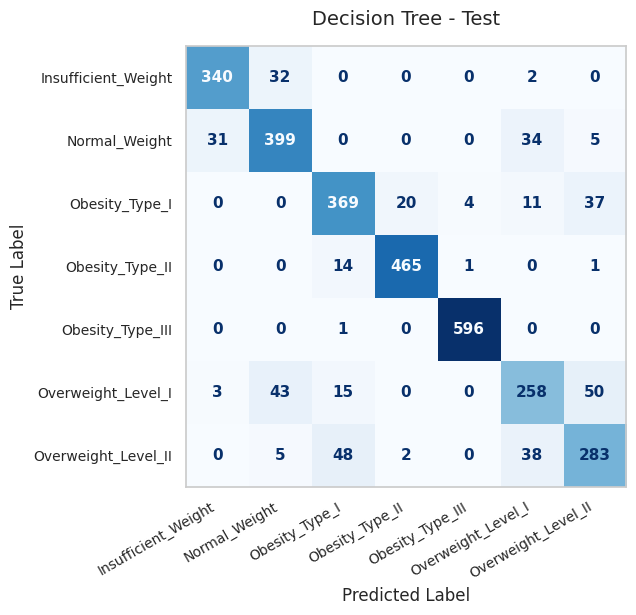

Random Forest - Test Accuracy: 89.22%


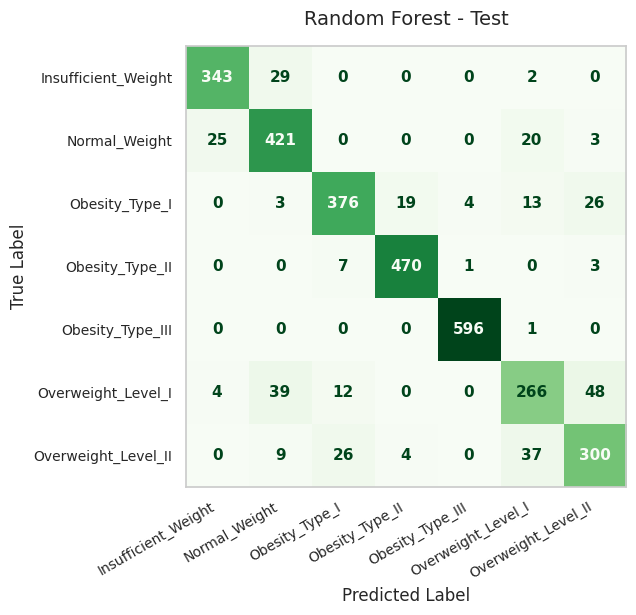

Gradient Boosting - Test Accuracy: 90.25%


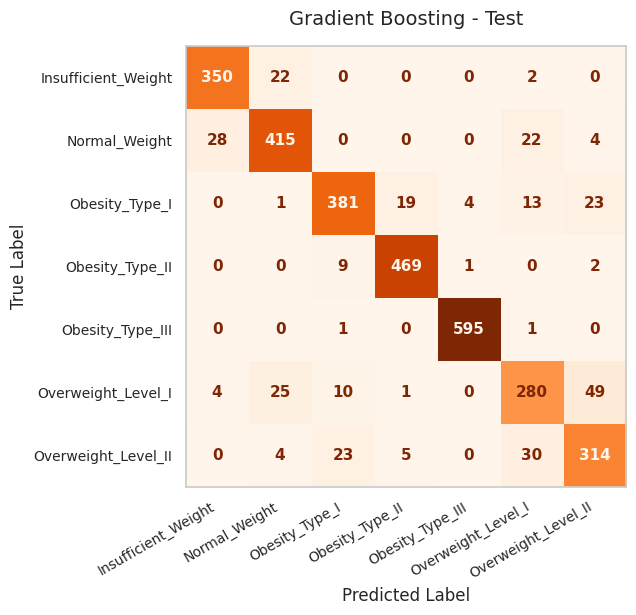

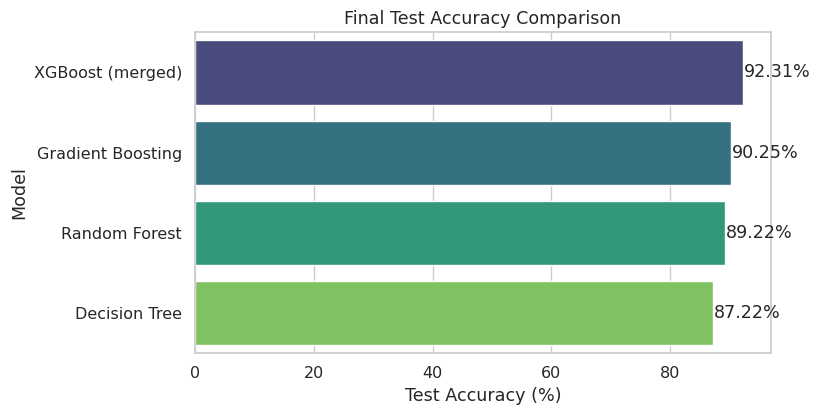

,Model,Test Accuracy (%)
3,XGBoost (merged),92.309875
2,Gradient Boosting,90.247827
1,Random Forest,89.217895
0,Decision Tree,87.222401


In [36]:
# Final evaluation on test set (models trained on train.csv)
y_test_pred_dt = best_dt.predict(preprocessor.transform(X_test))
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)
print(f'Decision Tree - Test Accuracy: {test_acc_dt*100:.2f}%')
plot_clean_confusion_matrix(y_test, y_test_pred_dt, le.classes_, 'Decision Tree - Test', cmap='Blues', figsize=(9,7))

y_test_pred_rf = best_rf.predict(preprocessor.transform(X_test))
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
print(f'Random Forest - Test Accuracy: {test_acc_rf*100:.2f}%')
plot_clean_confusion_matrix(y_test, y_test_pred_rf, le.classes_, 'Random Forest - Test', cmap='Greens', figsize=(9,7))

y_test_pred_gb = best_gb.predict(preprocessor.transform(X_test))
test_acc_gb = accuracy_score(y_test, y_test_pred_gb)
print(f'Gradient Boosting - Test Accuracy: {test_acc_gb*100:.2f}%')
plot_clean_confusion_matrix(y_test, y_test_pred_gb, le.classes_, 'Gradient Boosting - Test', cmap='Oranges', figsize=(9,7))

comparison_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost (merged)'],
    'Test Accuracy (%)': [test_acc_dt*100, test_acc_rf*100, test_acc_gb*100, test_acc_xgb*100]
}).sort_values(by='Test Accuracy (%)', ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(data=comparison_df, x='Test Accuracy (%)', y='Model', palette='viridis')
for i, val in enumerate(comparison_df['Test Accuracy (%)']):
    plt.text(val+0.1, i, f"{val:.2f}%", va='center')
plt.title('Final Test Accuracy Comparison')
plt.tight_layout(pad=3)
plt.show()
display(comparison_df)
